In [ ]:
#default_exp drawgraph

# drawgraph

> Drawing graphs with graphviz.

In [ ]:
#export
from fastcore.all import *

In [ ]:
#export
import pydot
from matplotlib.colors import rgb2hex, hex2color

In [ ]:
#export
_all_ = ['pydot']

In [ ]:
from nbdev.showdoc import *
from IPython.display import SVG

## Nodes and edges

In [ ]:
#export
def create_graph(defaults=None, rankdir='LR', directed=True, compound=True,
                 shape='box', style='rounded, filled', fillcolor='white', **kwargs):
    "Create a `Dot` graph with fastai/fastgraph style defaults"
    g = pydot.Dot(rankdir=rankdir, directed=directed, compound=compound, **kwargs)
    if defaults is None: defaults = dict(shape=shape, style=style, fillcolor=fillcolor)
    g.set_node_defaults(**defaults)
    return g

In [ ]:
#export
def _uniq_name(): return 'n'+(uuid4().hex)

@delegates(pydot.Node)
def Node(label, node=None, tooltip=None, **kwargs):
    "Create a `pydot.Node` with a unique name"
    if not isinstance(label,str) and isinstance(label, Collection) and len(label)==2:
        label,tooltip = label
    if tooltip is None: tooltip=label
    return pydot.Node(_uniq_name(), label=str(label), tooltip=tooltip, **kwargs)

@patch
def _repr_svg_(self:pydot.Dot):
    return self.create_svg().decode('utf-8')

In [ ]:
show_doc(Node)

<h4 id="Node" class="doc_header"><code>Node</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Node</code>(**`label`**, **`node`**=*`None`*, **`tooltip`**=*`None`*, **`name`**=*`''`*, **`obj_dict`**=*`None`*)

Create a `pydot.Node` with a unique name

`pydot` uses the same name-based approach to identifying graph items as `graphviz`. However we would rather use python objects. Therefore, we patch `pydot` to use unique names.

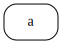

In [ ]:
g = create_graph()
g.add_node(Node('a'))
g

If a 2-tuple is passed to `add_node`, then the 2nd element becomes the tooltip (which is only visible with notebooks, not within HTML documentation).

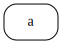

In [ ]:
g = create_graph()
g.add_node(Node(['a', "My tooltip"]))
g

In [ ]:
#export
@patch
@delegates(pydot.Node)
def create_node(self:pydot.Graph, label=None, node=None, **kwargs):
    "Create a `Node` and add to the `Graph`"
    if node is None: node = Node(label=label, **kwargs)
    self.add_node(node)
    return node

In [ ]:
show_doc(pydot.Graph.create_node)

<h4 id="Graph.create_node" class="doc_header"><code>Graph.create_node</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Graph.create_node</code>(**`label`**=*`None`*, **`node`**=*`None`*, **`name`**=*`''`*, **`obj_dict`**=*`None`*)

Create a [`Node`](drawgraph.html#Node) and add to the `Graph`

It's often easier to create a node and add to a graph in one step.

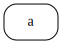

In [ ]:
g = create_graph()
g.create_node('a')
g

In [ ]:
#export
@patch
def create_edge(self:pydot.Graph, node1, node2, **kwargs):
    "Create an `Edge` and add to the `Graph`"
    edge = pydot.Edge(node1, node2, **kwargs)
    self.add_edge(edge)
    return edge

In [ ]:
show_doc(pydot.Graph.create_edge)

<h4 id="Graph.create_edge" class="doc_header"><code>Graph.create_edge</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Graph.create_edge</code>(**`node1`**, **`node2`**, **\*\*`kwargs`**)

Create an `Edge` and add to the `Graph`

With unique nodes, we can create edges directly between node objects.

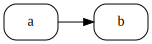

In [ ]:
g = create_graph()
g.create_edge(g.create_node('a'), g.create_node('b'))
g

In [ ]:
_cm = plt.get_cmap('Set3')
net_colors = ['#ffffff'] + [rgb2hex(array(_cm(i)[:3])) for i in range(_cm.N)]

In [ ]:
#export
def show_colormap(cm, figsize=(8,0.5)):
    "Utility function to display a matplotlib colormap"
    _,ax = plt.subplots(figsize=figsize)
    im = np.tile(np.linspace(0,1,cm.N), [2,1])
    ax.imshow(im, cmap=cm, aspect='auto');
    ax.axis('off')

The default colors provided by `drawgraph` are (along with white, which is `net_colors[0]`):

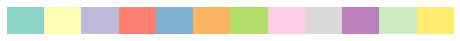

In [ ]:
#hide_input
show_colormap(_cm)

In [ ]:
#export
@patch
def create_nodes(self:pydot.Graph, labels, colors=None, **kwargs):
    "Create nodes for `labels` with optional `tooltips` and `colors`, and add to this `Graph`"
    if colors is None: colors = net_colors[:len(labels)]
    return L(self.create_node(n, fillcolor=c, **kwargs) for n,c in L(labels,colors).zip(cycled=True))

In [ ]:
show_doc(pydot.Graph.create_nodes)

<h4 id="Graph.create_nodes" class="doc_header"><code>Graph.create_nodes</code><a href="__main__.py#L1" class="source_link" style="float:right">[source]</a></h4>

> <code>Graph.create_nodes</code>(**`labels`**, **`colors`**=*`None`*, **\*\*`kwargs`**)

Create nodes for `labels` with optional `tooltips` and `colors`, and add to this `Graph`

In [ ]:
lbls = dict(conv='A conv', norm='Some norm', act='Activation').items()

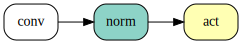

In [ ]:
g = create_graph()
ga,gb,gc = g.create_nodes(lbls, colors=net_colors[:3])
g.create_edge(ga, gb)
g.create_edge(gb, gc)
g

In [ ]:
#export
@patch
def add_edges_seq(self:pydot.Graph, nodes):
    "Add edges between each pair of `nodes` in sequence"
    return L(g.create_edge(nodes[i], nodes[i+1]) for i,o in enumerate(nodes[:-1]))

In [ ]:
show_doc(pydot.Graph.add_edges_seq)

<h4 id="Graph.add_edges_seq" class="doc_header"><code>Graph.add_edges_seq</code><a href="__main__.py#L1" class="source_link" style="float:right">[source]</a></h4>

> <code>Graph.add_edges_seq</code>(**`nodes`**)

Add edges between each pair of `nodes` in sequence

Here's a quicker way to create the previous graph (colors from `net_colors` are used automatically if `colors` not provided):

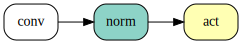

In [ ]:
g = create_graph()
nodes = g.create_nodes(lbls)
g.add_edges_seq(nodes)
g

## Clusters

In [ ]:
#export
@delegates(pydot.Cluster)
def Cluster(label='', **kwargs):
    return pydot.Cluster(_uniq_name(), label=label, **kwargs)

@patch
def create_subgraph(self:pydot.Graph, sg):
    "Same as `Graph.add_subgraph`, but also returns the subgraph"
    self.add_subgraph(sg)
    return sg

@patch
def create_cluster(self:pydot.Graph, label, tooltip=None, style='rounded, filled', fillcolor='#77777744', **kwargs):
    "Create a `Cluster` and add it to the `Graph`"
    if tooltip is None: tooltip=label
    sg = Cluster(label=label, style=style, tooltip=tooltip, fillcolor=fillcolor, **kwargs)
    g.add_subgraph(sg)
    return sg

@patch
def __getitem__(self:pydot.Cluster, i):
    "`i`th node in `Cluster`"
    return self.get_nodes()[i]

In [ ]:
show_doc(pydot.Graph.create_cluster)

<h4 id="Graph.create_cluster" class="doc_header"><code>Graph.create_cluster</code><a href="__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>Graph.create_cluster</code>(**`label`**, **`tooltip`**=*`None`*, **`style`**=*`'rounded, filled'`*, **`fillcolor`**=*`'#77777744'`*, **\*\*`kwargs`**)

Create a [`Cluster`](drawgraph.html#Cluster) and add it to the `Graph`

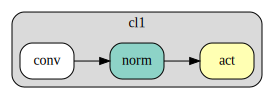

In [ ]:
g = create_graph()
sg = g.create_cluster('cl1')
nodes = sg.create_nodes(lbls)
g.add_edges_seq(nodes)
g

In [ ]:
#export
def create_net_graph(g, cluster_label, labels, colors=None, **kwargs):
    "Create a `Cluster` with `label` containing `nodes`"
    sg = g.create_cluster(cluster_label, **kwargs)
    nodes = sg.create_nodes(labels, colors)
    g.add_edges_seq(nodes)
    return sg

This is just a shortcut for doing all the steps in the previous example.

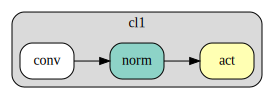

In [ ]:
g = create_graph()
sg = create_net_graph(g, 'cl1', lbls)
g

In [ ]:
#export
@patch
def connect_items(self:pydot.Graph, cl1, cl2):
    "Connect two nodes or clusters"
    a,b,ltail,lhead = cl1,cl2,'',''
    if isinstance(cl1,pydot.Cluster):
        a = cl1[-1]
        ltail=cl1.get_name()
    if isinstance(cl2,pydot.Cluster):
        b = cl2[0]
        lhead=cl2.get_name()
    return self.create_edge(a, b, lhead=lhead, ltail=ltail)

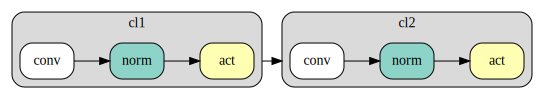

In [ ]:
g = create_graph()
sg1 = create_net_graph(g, 'cl1', lbls)
sg2 = create_net_graph(g, 'cl2', lbls)
g.connect_items(sg1, sg2)
g

As well as connecting `Cluster`s, you can also connect any combination of `Cluster`s and `Nodes`.

Note that `drawgraph` adds `__getitem__` to `Cluster`, which makes it easy to connect to different `Node`s inside a `Cluster`.

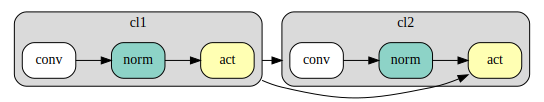

In [ ]:
g = create_graph()
sg1 = create_net_graph(g, 'cl1', lbls)
sg2 = create_net_graph(g, 'cl2', lbls)
g.connect_items(sg1, sg2)
g.connect_items(sg1, sg2[-1])
g

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_drawgraph.ipynb.
Converted 00_fastgraph.ipynb.
Converted index.ipynb.
